In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cmcrameri import cm

import os
from pathlib import Path
import shutil
import gzip
import re

import timeit


In [5]:
from cosmic.sample.initialbinarytable import InitialBinaryTable
from cosmic.evolve import Evolve
from cosmic.plotting import evolve_and_plot

In [ ]:
median_giant_masses = []
# Load the CSV file into a numpy array
data = np.loadtxt(output_file_nocollision, delimiter=',', dtype=str, skiprows=1)
for i in range(2,6):
        
    # Check k
    check_k = np.array(data[:, 19], dtype=float) == float(i)
    data_k = data[check_k]

    # Check z
    check_z = np.array(data_k[:, 3], dtype=float) == 0.02
    data_z = data_k[check_z]

    # Check age
    check_old = np.array(data_z[:, 4], dtype=float) > 9e3
    data_old = data_z[check_old]

    mass_BH = data_old[::, 9].astype(float)
    mass_Giant = data_old[::, 11].astype(float)
    type_Giant = data_old[::, 19].astype(float)
    times_GiantBH = data_old[::, 4].astype(float)
    print(len(mass_Giant))

    colors = cm.batlow(np.linspace(0, 1, len(set(type_Giant))))

    # Get unique numbers from the list
    unique_numbers = list(set(type_Giant))
    unique_numbers.sort()

    # Create a mapping of unique numbers to colors
    N_to_color = {num: colors[i % len(colors)] for i, num in enumerate(unique_numbers)}
    colors_N = [N_to_color[N] for N in type_Giant]

    # Get percentages for each type
    fractions = [100 * list(type_Giant).count(N) / len(type_Giant) for N in unique_numbers]

    fig, ax = plt.subplots(figsize=(10, 6))

    scatter = ax.scatter(mass_BH, mass_Giant, s=1, color=colors_N)

    median_BH = np.median(mass_BH)
    median_Giant = np.median(mass_Giant)
    median_BH_line = ax.axvline(median_BH, color='red', linestyle='--', label=rf'Median BH mass: {median_BH:.2f} $M_\odot$')
    median_Giant_line = ax.axhline(median_Giant, color='red', linestyle='--', label=rf'Median Giant mass: {median_Giant:.2f} $M_\odot$')

    mass_Giant_30 = np.percentile(mass_Giant, 30)
    mass_Giant_70 = np.percentile(mass_Giant, 70)
    mass_BH_30 = np.percentile(mass_BH, 30)
    mass_BH_70 = np.percentile(mass_BH, 70)

    percentiles = ax.axhspan(mass_Giant_30, mass_Giant_70, color='gray', alpha=0.2, lw=0, label="70th percentiles")
    ax.axvspan(mass_BH_30, mass_BH_70, color='gray', alpha=0.2, lw=0)

    ax.set_xlabel(r'BH mass ($M_{\odot}$)')
    ax.set_ylabel(r'Giant mass ($M_{\odot}$)')
    ax.set_title('Giant mass vs BH mass: $Z=0.02$, $t>9$ Gyr')
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Define the dictionary for the mapping
    stage_mapping = {
        0: "Main Sequence (MS), $< 0.7 M_\odot$",
        1: "MS, $> 0.7 M_\odot$",
        2: "Hertzsprung Gap",
        3: "First Giant Branch",
        4: "Core Helium Burning",
        5: "Early Asymptotic Giant Branch (AGB)",
        6: "Thermally Pulsing AGB",
        7: "Naked Helium Star MS",
        8: "Naked Helium Star Hertzsprung Gap",
        9: "Naked Helium Star Giant Branch",
        10: "Helium White Dwarf",
        11: "Carbon/Oxygen White Dwarf",
        12: "Oxygen/Neon White Dwarf",
        13: "Neutron Star",
        14: "Black Hole",
        15: "Massless Remnant"
    }

    # Replace integers with corresponding text
    giant_name_types = [stage_mapping[num] for num in unique_numbers]

    # Create a legend
    legend_labels = {stage_mapping[N]: f'{stage_mapping[N]} ({frac:.2f}%)' for N, frac in zip(unique_numbers, fractions)}
    legend_handles = []
    for N in unique_numbers:
        label = legend_labels[stage_mapping[N]]
        color = N_to_color[N]
        legend_handles.append(ax.scatter([], [], c=color, label=label))
    first_legend = ax.legend(handles=legend_handles, loc='best')
    ax.add_artist(first_legend)  # Add the first legend as an artist to the axes

    # Create the second legend for the median lines
    median_legend = ax.legend(handles=[median_BH_line, median_Giant_line, percentiles], loc='lower right')

    median_giant_masses.append(median_Giant)


In [ ]:
print(median_giant_masses)

In [45]:
for mass in median_giant_masses:
    
    single_binary = InitialBinaryTable.InitialBinaries(m1=mass, m2=0.001, porb=1000000, ecc=0, tphysf=13700.0, kstar1=1, kstar2=1, metallicity=0.02)

    BSEDict = {'xi': 1.0, 'bhflag': 1, 'neta': 0.5, 'windflag': 3, 'wdflag': 1, 'alpha1': 1.0, 'pts1': 0.001, 'pts3': 0.02, 'pts2': 0.01, 'epsnov': 0.001, 'hewind': 0.5, 'ck': 1000, 'bwind': 0.0, 'lambdaf': 0.0, 'mxns': 3.0, 'beta': -1.0, 'tflag': 1, 'acc2': 1.5, 'grflag' : 1, 'remnantflag': 4, 'ceflag': 0, 'eddfac': 1.0, 'ifflag': 0, 'bconst': 3000, 'sigma': 265.0, 'gamma': -2.0, 'pisn': 45.0, 'natal_kick_array' : [[-100.0,-100.0,-100.0,-100.0,0.0], [-100.0,-100.0,-100.0,-100.0,0.0]], 'bhsigmafrac' : 1.0, 'polar_kick_angle' : 90, 'qcrit_array' : [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], 'cekickflag' : 2, 'cehestarflag' : 0, 'cemergeflag' : 0, 'ecsn' : 2.25, 'ecsn_mlow' : 1.6, 'aic' : 1, 'ussn' : 0, 'sigmadiv' :-20.0, 'qcflag' : 1, 'eddlimflag' : 0, 'fprimc_array' : [2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0,2.0/21.0], 'bhspinflag' : 0, 'bhspinmag' : 0.0, 'rejuv_fac' : 1.0, 'rejuvflag' : 0, 'htpmb' : 1, 'ST_cr' : 1, 'ST_tide' : 1, 'bdecayfac' : 1, 'rembar_massloss' : 0.5, 'kickflag' : 0, 'zsun' : 0.014, 'bhms_coll_flag' : 0, 'don_lim' : -1, 'acc_lim' : -1, 'rtmsflag' : 0, 'wd_mass_lim': 1}

    bpp, bcm, initC, kick_info = Evolve.evolve(initialbinarytable=single_binary, BSEDict=BSEDict)

    #fig = evolve_and_plot(single_binary, t_min=None, t_max=None, BSEDict=BSEDict, sys_obs={})

    bpp = bpp[['tphys', 'massc_1', 'rad_1', 'kstar_1', 'radc_1', 'evol_type']]
    print(bpp)


In [ ]:
print(bpp.columns)

/Users/wyang10/anaconda3/envs/cassi/lib/python3.10/site-packages/cosmic/evolve.py:258: UserWarning: The value for dtp in initial binary table is being overwritten by the value of dtp from either the params file or the BSEDict.
  warnings.warn("The value for {0} in initial binary table is being "


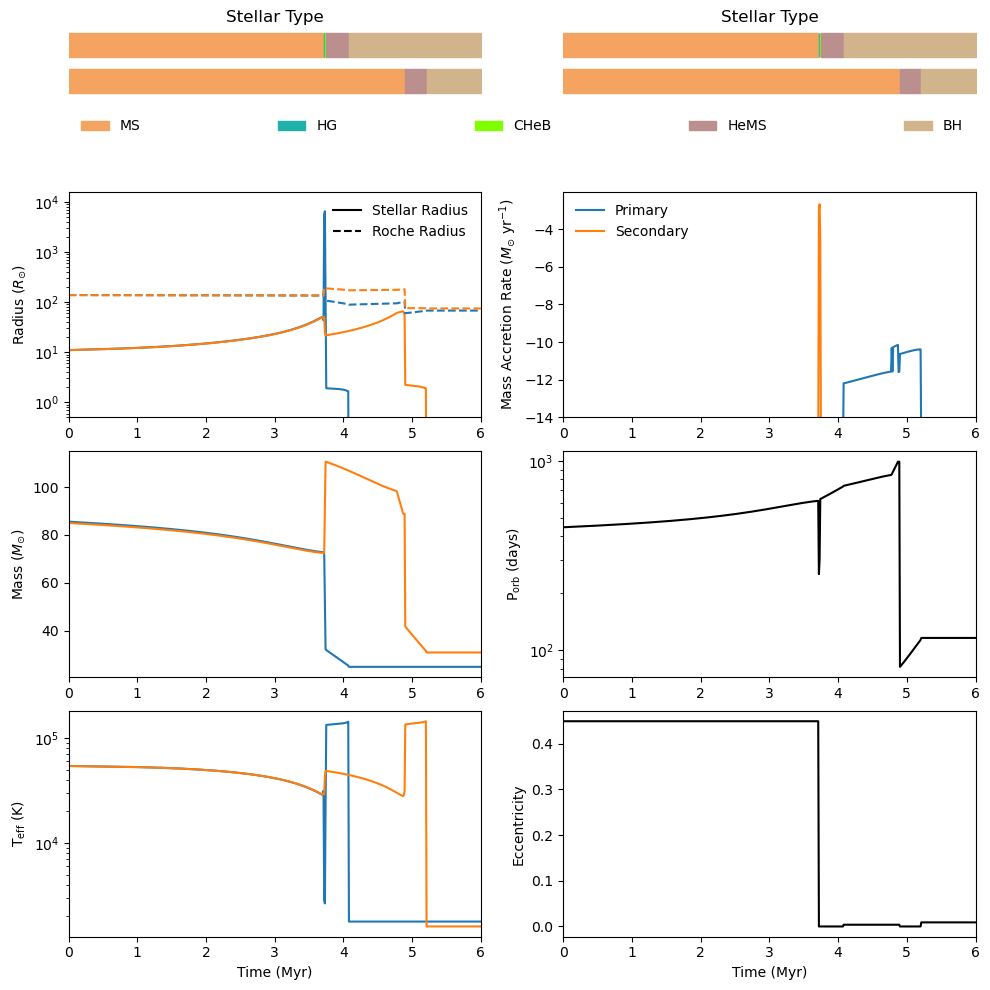

In [17]:
fig = evolve_and_plot(initC, t_min=None, t_max=6.0, BSEDict={}, sys_obs={})
